In [1]:
import cv2 
import numpy as np
import matplotlib.pyplot as plt

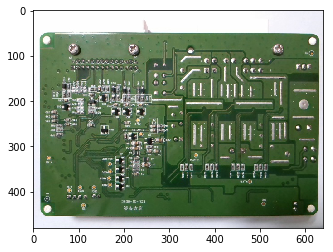

In [2]:
image_path = 'source_image/1560820945.jpg'
image = cv2.imread(image_path)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

## PCB区域提取
### 一、基于颜色饱和度直方图对图片进行裁剪
在计算机中最常用的彩色图像模型是RGB模型，该模型通过每种颜色在红、绿、蓝三原色光谱分量中的投影值，来确定其在颜色空间中的坐标位置。使用RGB模型可以很方便地在计算机中描述一幅彩色图像的颜色信息，但是这并不是人眼直观感知物体颜色的方式，人眼往往从色调、饱和度以及亮度这三个方面来感知物体的颜色。色调描述的是一种纯色的颜色属性，饱和度描述的是一种纯色被白光稀释的程度，计算机中的HSV彩色模型便采用了该方式对彩色图片进行描述。因此HSV模型是开发基于色彩描述的图像处理算法的理想工具，PCB区域提取算法也是在HSV模型下设计的。  
而我们通过相机采集得到的原始图像是RGB格式的，因此在图像处理阶段，需要先RGB模型到HSV模型的转换，该转换是基于图像的每一像素单独进行的，转换方式如下所示：  
**H分量：**
\begin{equation}
H=
\begin{cases}
\begin{aligned}
\theta, \quad &B\le G\\
360-\theta, \quad&B>G
\end{aligned}
\end{cases},\quad
其中：
\theta=arccos\{ \frac {\frac 12 [(R-B)+(R-G)]}{[(R-G)^2+(R-B)(G-B)]^{1/2}} \}
\end{equation}
**S分量：**
\begin{equation}
S=1- \frac 3{R+G+B}[min(R, G, B)]
\end{equation}
**V分量：**
\begin{equation}
V=\frac 13(R+G+B)
\end{equation}

[None]


Text(0.5, 1.0, 'source image')

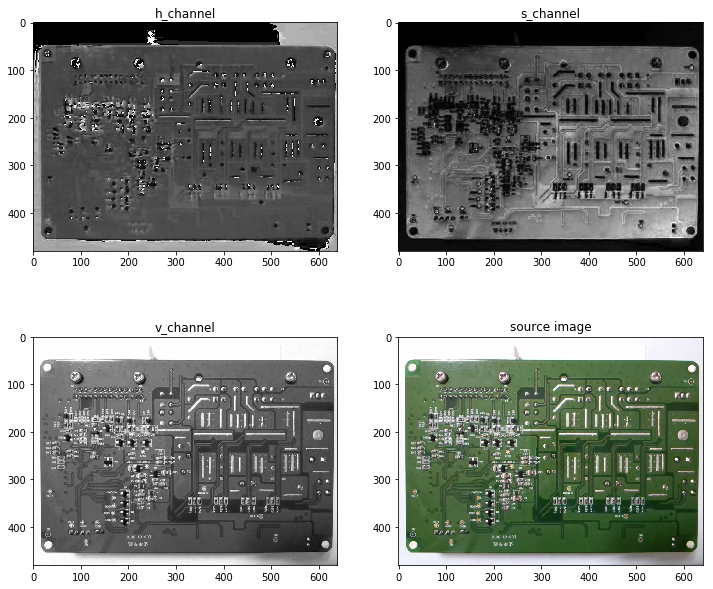

In [3]:
hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
fig, axes = plt.subplots(2, 2)
print(plt.setp(fig, size_inches=[12, 10]))
plt.subplots_adjust(top=0.9, bottom=0.1,wspace=0.2, hspace=0.2)
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
axes[0][0].imshow(hsv_image[..., 0], cmap='gray')
axes[0][0].set_title("h_channel")
axes[0][1].imshow(hsv_image[..., 1], cmap='gray')
axes[0][1].set_title("s_channel")
axes[1][0].imshow(hsv_image[..., 2], cmap='gray')
axes[1][0].set_title("v_channel")
axes[1][1].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
axes[1][1].set_title("source image")

In [4]:
s_image = hsv_image[..., 1]

**高斯滤波**
$$
\frac 1{{2\pi}\sigma^2}e^{-\frac {(x-\bar{x})^2 + {(y-\bar{y})^2}}{2\sigma ^2}}
$$

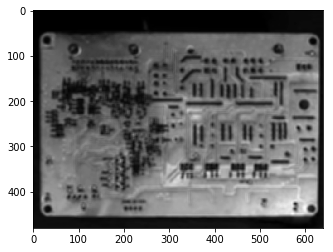

In [5]:
gauss_image = cv2.GaussianBlur(s_image, ksize=(7, 7), sigmaX=15, sigmaY=15)
plt.imshow(gauss_image, cmap='gray')

**双边滤波**

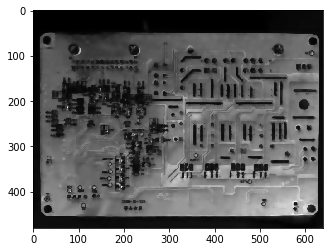

In [6]:
bilater_image = cv2.bilateralFilter(s_image, 10, 20, 30)
plt.imshow(bilater_image, cmap='gray')

66.0


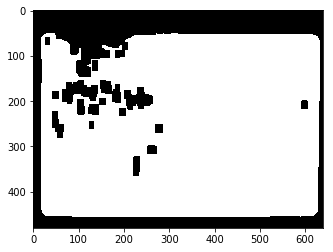

In [7]:
thresh, thresh_image = cv2.threshold(bilater_image, 0, 1, cv2.THRESH_OTSU)

# thresh_image = cv2.adaptiveThreshold(bilater_image, 255, \
#                                              cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
#                                              cv2.THRESH_BINARY, 15, 0)
width, height = thresh_image.shape[:2]
kernel = np.ones((int(height/40), int(width/40)))
thresh_image = cv2.morphologyEx(thresh_image, cv2.MORPH_CLOSE, kernel)
print(thresh)
plt.imshow(thresh_image, cmap='gray')

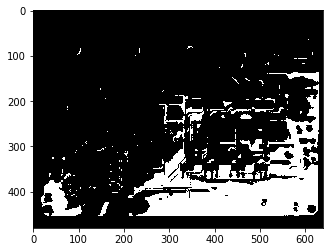

In [8]:
plt.imshow(cv2.threshold(bilater_image, 125, 255, cv2.THRESH_BINARY)[1], cmap="gray")

angle:  -0.0


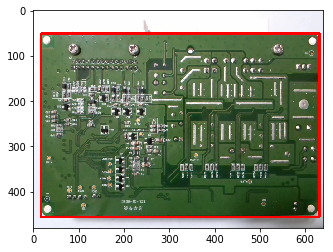

In [9]:
height, width = thresh_image.shape[:2]
_, contours, hierarchy = cv2.findContours(thresh_image, cv2.RETR_TREE,
		cv2.CHAIN_APPROX_SIMPLE)
contour_img = np.zeros((height, width, 3), np.uint8)
contours_poly = []
for index, contour in enumerate(contours):
    if cv2.contourArea(contour) > height * width / 4:
        # 对于符合条件的轮廓，得到逼近多边形的坐标
        contours_poly.append(cv2.approxPolyDP(contour, epsilon=5, closed=True))
        rect = cv2.minAreaRect(contour)       # 找到最小外接矩形
        cv2.drawContours(contour_img, contours, index, (255, 255, 255), 2)
        contours_poly0 = contours_poly[0]
center_x, center_y = rect[0]
rect_w, rect_h = rect[1]
angle = rect[2]
points = cv2.boxPoints(rect)
image_rect = image.copy()
for i in range(len(points)):
    cv2.line(image_rect, tuple(points[i]), tuple(points[(i+1)%4]), (0, 0, 255), 3)
plt.imshow(cv2.cvtColor(image_rect, cv2.COLOR_BGR2RGB))
print("angle: ", angle)

通过rect的中心点以及角度信息对原图进行旋转调整，使其处于水平

In [10]:
if abs(angle) >= 45:
    rotate_angle = 90 + angle
else:
    rotate_angle = angle
rotate_matrix = cv2.getRotationMatrix2D(rect[0], rotate_angle, scale=1)
print("rotate matrix: ", rotate_matrix)

rotate matrix:  [[ 1. -0.  0.]
 [ 0.  1.  0.]]


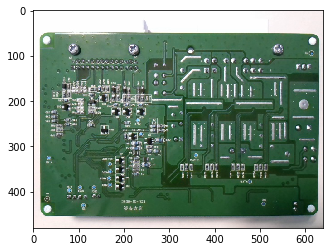

In [11]:
rotate_image = cv2.warpAffine(image, rotate_matrix, image.shape[1::-1])
plt.imshow(rotate_image)

In [12]:
print(points)
print(np.ones((4, 1)))
points = np.transpose(np.concatenate([points, np.ones((4, 1))], axis = -1))
print(points)

[[ 17. 455.]
 [ 17.  51.]
 [632.  51.]
 [632. 455.]]
[[1.]
 [1.]
 [1.]
 [1.]]
[[ 17.  17. 632. 632.]
 [455.  51.  51. 455.]
 [  1.   1.   1.   1.]]


In [13]:
points = np.transpose(np.int0(np.matmul(rotate_matrix, points)))
print("new points: ", points)

new points:  [[ 17 455]
 [ 17  51]
 [632  51]
 [632 455]]


In [14]:
x_min = np.min(points, axis=0)[0]
y_min = np.min(points, axis=0)[1]
print("x_min: {0}, y_min: {1}".format(x_min, y_min))
x_max, y_max = np.max(points, axis=0)
print("x_max: {0}, y_max: {1}".format(x_max, y_max))

x_min: 17, y_min: 51
x_max: 632, y_max: 455


True

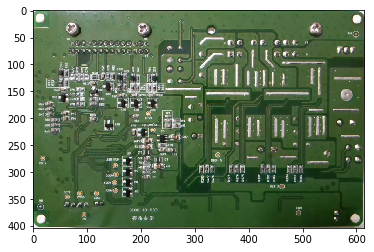

In [15]:
pcb_image = rotate_image[y_min: y_max, x_min: x_max, :]
plt.imshow(cv2.cvtColor(pcb_image, cv2.COLOR_BGR2RGB))
cv2.imwrite("source_image/pcb1.jpg", pcb_image)

### harris 角点检测分析

### LoG 高斯拉普拉斯算法分析

高斯公式：
$$
g(x,y,\sigma)=\frac 1{2\pi \sigma^2}e^{-\frac {x^2+y^2}{2\sigma^2}}
$$

In [16]:
from math import pi
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib as mpl
plt.rcParams['legend.fontsize']=10

In [17]:
height, width = [5, 5]
sigma = 1.
y, x = np.mgrid[0: height:0.2, 0: width:0.2]
scale = -1/(pi * sigma**2)
print("scale: ", scale)
scale2 = (1 - ((x-width/2)**2+(y-height/2)**2)/(2*sigma**2))
# print("scale2: ", scale2)
exp = scale * scale2 * np.exp(-((x-width/2)**2+(y-height/2)**2)/(2*sigma**2))

scale:  -0.3183098861837907


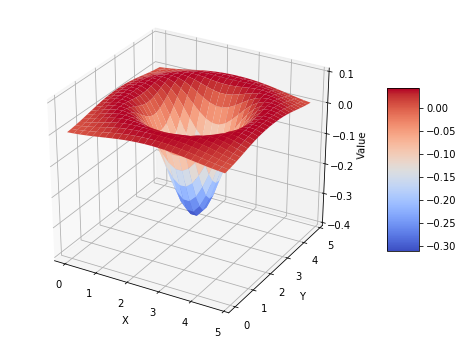

In [18]:
fig = plt.figure(figsize=(8, 6))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(x, y, exp, cmap=mpl.cm.coolwarm)
ax.set_zlim(-0.4, 0.1)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Value")
fig.colorbar(surf, shrink=0.5, aspect=5)
# ax.zaxis.set_major_locator(LinearLocator(10))

In [19]:
import sympy
x, y, sigma, g = sympy.symbols("x, y, sigma, g")
scale = -1/(sympy.pi * sigma**2)
scale2 = (1 - (x**2+y**2)/(2*sigma**2))
scale2 * scale

-(1 - (x**2 + y**2)/(2*sigma**2))/(pi*sigma**2)

1.7677669529663687


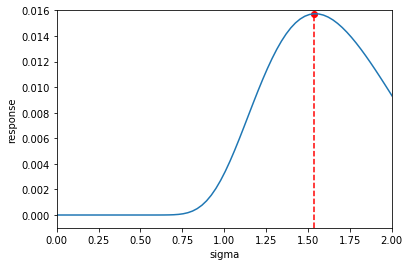

In [20]:
_exp = scale * scale2 * sympy.exp(-(x**2+y**2)/(2*sigma**2))
exp_func = sympy.lambdify([sigma, x, y], _exp, modules='numpy')
_sigma = np.linspace(0.001, 2.5/np.sqrt(2)+1, 100)
response = exp_func(_sigma, 2.5, 2.5)
plt.plot(_sigma, response)
plt.ylim(-0.001, 0.016)
plt.xlim(0, 2.)
plt.xlabel(u"sigma")
plt.ylabel(u"response")
max_response_index = np.argmax(response)
plt.scatter(_sigma[max_response_index], response[max_response_index], color='r')
plt.plot([_sigma[max_response_index], _sigma[max_response_index]], 
        [-0.001, response[max_response_index]], '--', color='r')
print(2.5/np.sqrt(2))

In [21]:
x, y, sigma, g = sympy.symbols("x, y, sigma, g")
scale = -1/(sympy.pi * sigma**2)
scale2 = (1 - (x**2+y**2)/(2*sigma**2))
sympy.simplify(_exp.diff(sigma, 1))

(4*sigma**2*(sigma**2 - x**2 - y**2) - (x**2 + y**2)*(2*sigma**2 - x**2 - y**2))*exp(-(x**2 + y**2)/(2*sigma**2))/(2*pi*sigma**7)

In [22]:
g = 1/(2*sympy.pi*sigma**2)*sympy.exp(-(x**2+y**2)/(2*sigma**2))
g = sympy.simplify(sigma**2 * (g.diff(x, 2)+g.diff(y, 2)).doit())
sympy.simplify(g.diff(sigma, 1))

(-4*sigma**4 + 4*sigma**2*(2*sigma**2 - x**2 - y**2) + (x**2 + y**2)*(-2*sigma**2 + x**2 + y**2))*exp(-(x**2 + y**2)/(2*sigma**2))/(2*pi*sigma**7)

In [23]:
# # Standard imports
# # Read image
# im = cv2.cvtColor(pcb_image, cv2.COLOR_BGR2GRAY)
# # Set up the detector with default parameters.
# detector = cv2.SimpleBlobDetector()
# # Detect blobs.
# keypoints = detector.detect(im)
# # Draw detected blobs as red circles.
# # cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS ensures the size of the circle corresponds to the size of blob
# im_with_keypoints = cv2.drawKeypoints(im, keypoints, np.array([]), 
#                                       (0,0,255), 
#                                       cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
# plt.imshow()

## SIFT

In [57]:
kernel_w, kernel_h = [10, 10]
gauss = 1/(sympy.sqrt(2*sympy.pi)*sigma)*sympy.exp(-(x-kernel_w/2)**2/(2 * sigma**2))
print("gauss function:")
gauss

gauss function:


sqrt(2)*exp(-(x - 5.0)**2/(2*sigma**2))/(2*sqrt(pi)*sigma)

In [58]:
laplacian = sigma * gauss.diff(x, 2)
laplacian

-sqrt(2)*(1 - (2*x - 10.0)**2/(4*sigma**2))*exp(-(x - 5.0)**2/(2*sigma**2))/(2*sqrt(pi)*sigma**2)

SIFT算法建议，在某一个尺度上对斑点的检测，可以通过对两个相邻高斯尺度空间的图像相减，得到一个DoG（Difference of Gaussian）的响应值图像$D(x, y,\sigma)$。然后仿照LoG方法，通过对响应值图像$D(x, y, \sigma)$进行非极大值抑制（局部极大搜索），在位置空间和尺度空间中定位斑点。其中：
$$
D(x, y, \sigma)=(G(x, y, k\sigma)-G(x, y, \sigma))\otimes I(x, y)
$$

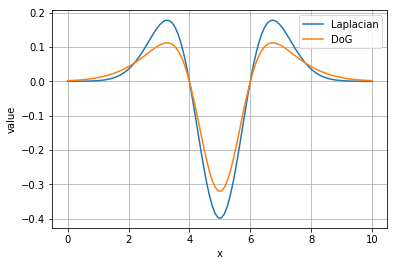

In [108]:
lap_func = sympy.lambdify([sigma, x], laplacian, "numpy")
gauss_func = sympy.lambdify([sigma, x], gauss, "numpy")
value1 = lap_func(1, np.linspace(0, 10, 100))
value2 = gauss_func(1.6, np.linspace(0, 10, 100)) - gauss_func(0.7, np.linspace(0, 10, 100))
plt.plot(np.linspace(0, 10, 100), value1, label=r"Laplacian")
plt.plot(np.linspace(0, 10, 100), value2, label=r"DoG")
plt.grid('on')
# plt.text(7.5, 0.15, r"Laplacian")
plt.xlabel(r"x")
plt.ylabel(r"value")
plt.legend()